### Imports

In [1]:
import numpy as np
import pandas as pd
import csv
import json
import argparse
from sklearn.metrics import accuracy_score
import graphviz
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import classification_report
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Definitions

In [2]:
class_numbers = ['discord', 'whatsapp', 'signal', 'telegram', 'messenger', 'teams']
features = [' Min differential Packet Length', ' Max differential Packet Length', ' IAT min', ' IAT max', ' Packet Length Total']

In [3]:
# Function to get scores of the model under test
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test):

    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=4,
                                    random_state=42, bootstrap=False, class_weight='balanced')
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    class_report = classification_report(y_test, y_pred, target_names=class_numbers, output_dict = True)
    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

# Function to save final model for later analysis
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

# Function to separate data into features and labels
def extract_x_y(Dataset, classes, features):
    Dataset = Dataset[Dataset["Label"].isin(class_numbers)]
    X = Dataset[features]
    y = Dataset['Label'].replace(class_numbers, range(len(class_numbers)))
    return X, y

# Function to Fit model based on optimal values of depth and number of estimators and use it
# to compute feature importance for all the features.
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train):
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree,
                                    max_leaf_nodes=max_leaf, random_state=42, bootstrap=False, class_weight='balanced')
    rf_opt.fit(X_train, y_train)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    feature_importance.index = X_train.columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)

    return feature_importance

# Function to Fit model based on optimal values of depth and number of estimators and feature importance
# to find the fewest possible features to exceed the previously attained score with all selected features
def get_fewest_features(importance):
    sorted_feature_names = importance.index
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

# Function to analyze different combinations of model hyperparameters
def analyze_models(class_numbers, model_type, depths, n_trees, X_train, y_train, X_test, y_test, max_leaf, filename_out):
    # Create a list to hold the results
    results = []

    if model_type == 'RF':
        # FOR EACH (depth, n_tree, feat)
        for depth in depths:
            for n_tree in n_trees:
                # get feature orders to use
                importance = get_feature_importance(depth, n_tree, max_leaf, X_train, y_train)
                print(importance)
                plt.figure(figsize=(10, 6))
                plt.barh(importance.index, importance[0])
                plt.gca().invert_yaxis()
                plt.title("Feature Importance in Random Forest")
                plt.xlabel("Importance Score")
                plt.ylabel("Feature")
                plt.tight_layout()
                plt.show()
                m_feats = get_fewest_features(importance)
                for feats in m_feats:
                    # Get the scores with the given (depth, n_tree, feat)
                    model, c_report, macro_f1, weight_f1, y_pred = get_scores(
                        class_numbers, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test
                    )

                    # Append results as a dictionary
                    results.append({
                        "depth": depth,
                        "n_tree": n_tree,
                        "max_leaf": max_leaf,
                        "n_feat": len(feats),
                        "macro": macro_f1,
                        "weighted": weight_f1,
                        "features": list(feats),  # Convert features to a list
                        "c_report": c_report  # Add the classification report
                    })

    # Write the results to a .json file
    with open(filename_out, mode="w") as file:
        json.dump(results, file, indent=4)  # Pretty-print JSON with an indentation of 4 spaces

    print("Analysis Complete. Check output file.")
    return []

def find_best_parameters(json_file, metric="weighted"):
    # Load the JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Check if data is empty
    if not data:
        print("The JSON file is empty!")
        return None

    # Find the best configuration based on the specified metric
    best_config = max(data, key=lambda x: x[metric])

    # Print summary including depth
    print("Best Configuration:")
    print(f"Depth: {best_config['depth']}")
    print(f"N_tree: {best_config['n_tree']}")
    print(f"Max_leaf: {best_config['max_leaf']}")
    print(f"Number of Features: {best_config['n_feat']}")
    print(f"{metric.capitalize()} F1 Score: {best_config[metric]}")
    print(f"Features: {best_config['features']}")
    print(f"Classification Report: {best_config['c_report']}")

    return best_config

def evaluate_model_overfitting(model, X_train, y_train, X_test, y_test):
    # Evaluate training performance
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)

    # Evaluate test performance
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Analyze performance difference
    performance_diff = train_accuracy - test_accuracy
    if performance_diff > 0.1:  # Large gap between train and test
        evaluation = "The model is likely overfitting. Try regularization or simplifying the model."
    elif train_accuracy < 0.6 and test_accuracy < 0.6:  # Both low accuracies
        evaluation = "The model is likely underfitting. Try increasing complexity or adding more features."
    else:
        evaluation = "The model has a good balance between training and testing performance."

    # Print and return results
    results = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Report": train_report,
        "Test Report": test_report,
        "Evaluation": evaluation
    }

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Performance Difference: {performance_diff}")
    print(f"Evaluation: {evaluation}")

    return results

# --- Plot Confusion Matrix as a Heatmap ---

def plot_confusion_matrix(conf_matrix, labels, save_path="confusion_matrix.png"):
    labels = ['Discord', 'WhatsApp', 'Signal', 'Telegram', 'Messenger', 'Teams']

    # Scale accuracy values to percentages
    conf_matrix = np.round(conf_matrix * 100, 2)

    plt.figure(figsize=(12, 10))
    plt.rcParams["font.family"] = "Quattrocento Sans"

    heatmap = sns.heatmap(
        conf_matrix,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={'size': 22}
    )

    plt.xlabel("Predicted (Classes)", fontsize=22)
    plt.ylabel("Actual (Classes)", fontsize=22)

    # Set tick label font sizes and align x labels to center under ticks
    plt.xticks(rotation=30, ha='center', fontsize=22)
    plt.yticks(rotation=0, fontsize=22)

    # Colorbar customization
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([0, 20, 40, 60, 80, 100])
    colorbar.set_ticklabels(["0", "20", "40", "60", "80", "100"])
    colorbar.ax.tick_params(labelsize=22)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


def plot_metrics_bar_chart(accuracy, precision, recall, weighted_f1, macro_f1, save_path="metrics_plot.png"):
    metrics = ["Accuracy", "Precision", "Recall", "Weighted F1", "Macro F1"]
    scores = [accuracy, precision, recall, weighted_f1, macro_f1]

    font_size = 44  # Set the desired font size for all elements

    plt.figure(figsize=(24, 12))  # Increase width for better spacing
    bars = plt.bar(metrics, scores, color=["navy", "darkblue", "royalblue", "steelblue", "skyblue"])
    plt.ylim(60, 100)

    # Adding text annotations with specified font properties
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, score + 1, f"{score:.1f}",
                 ha="center", fontsize=font_size, fontfamily="Quattrocento Sans")

    # Apply font size to axis labels, title, and ticks
    plt.ylabel("Score [%]", fontsize=font_size, fontfamily="Quattrocento Sans")
    plt.xticks(fontsize=font_size, fontfamily="Quattrocento Sans")  # Rotate for spacing
    plt.yticks(fontsize=font_size, fontfamily="Quattrocento Sans")
    plt.title("Model Performance Metrics", fontsize=font_size, fontfamily="Quattrocento Sans")

    # Save the image
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Define ANSI escape code for #8F493F (approximate as a terminal color)
COLOR_CODE = "\033[38;2;143;73;63m"  # RGB escape sequence for the desired color
RESET_CODE = "\033[0m"  # Reset color

# --- Function to Compute TP, TN, FP, FN for Each Class ---
def compute_per_class_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    num_classes = conf_matrix.shape[0]  # Number of classes
    TP = np.diag(conf_matrix)  # True Positives
    FP = conf_matrix.sum(axis=0) - TP  # False Positives
    FN = conf_matrix.sum(axis=1) - TP  # False Negatives
    TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives

    return TP, TN, FP, FN

# --- Function to Display Per-Class Metrics with Color ---
def display_per_class_metrics(y_true, y_pred):
    labels = sorted(np.unique(y_true))  # Extract unique class labels
    TP, TN, FP, FN = compute_per_class_metrics(y_true, y_pred)

    print(f"\n{COLOR_CODE}=== Per-Class Confusion Metrics ==={RESET_CODE}")
    for i, label in enumerate(labels):
        print(f"{COLOR_CODE}Class {label}:{RESET_CODE}")
        print(f"{COLOR_CODE}  - TP: {TP[i]}, TN: {TN[i]}, FP: {FP[i]}, FN: {FN[i]}{RESET_CODE}")
        print(f"{COLOR_CODE}" + "-" * 40 + f"{RESET_CODE}")

# --- Function to Plot the Confusion Matrix for Each Class ---
def plot_per_class_metrics(y_true, y_pred):
    labels = sorted(np.unique(y_true))  # Extract unique class labels
    TP, TN, FP, FN = compute_per_class_metrics(y_true, y_pred)

    # Create subplots for each class
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust layout for 6 classes

    for idx, ax in enumerate(axes.flat):
        if idx >= len(labels):
            ax.axis("off")  # Hide extra subplots if classes are less than 6
            continue

        # Confusion Matrix for the class
        matrix = np.array([[f"TP\n{TP[idx]}", f"FP\n{FP[idx]}"],
                           [f"FN\n{FN[idx]}", f"TN\n{TN[idx]}"]])
        colors = np.array([[0, 1], [1, 0]])  # Blue for TP & TN, White for FP & FN

        # Heatmap with custom font properties
        sns.heatmap(colors, annot=matrix, fmt='', cmap="Blues", cbar=False,
                    xticklabels=["+", "-"], yticklabels=["+", "-"],
                    annot_kws={'size': 45, 'fontfamily': 'Quattrocento Sans'}, ax=ax)

        ax.set_xlabel("Actual Class", fontsize=40, fontname="Quattrocento Sans")
        ax.set_ylabel("Predicted Class", fontsize=40, fontname="Quattrocento Sans")
        ax.set_title(f"Class {labels[idx]}", fontsize=40, fontname="Quattrocento Sans")

    plt.tight_layout()
    plt.savefig("per_class_confusion_matrices.png", dpi=300, bbox_inches="tight")  # Save figure
    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load input data

In [5]:
train_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NIMS_IMA_train_data.csv")
train_data = train_data[train_data['Label'].isin(class_numbers)]
train_data.describe()

,Min Packet Length,Max Packet Length,Packet Length Total,Min differential Packet Length,Max differential Packet Length,IAT min,IAT max,Flow Duration
count,40405.000000,40405.000000,40405.000000,40405.000000,40405.000000,40405.000000,4.040500e+04,4.040500e+04
mean,68.156317,862.426729,2869.800198,49.495434,750.775993,394.945007,1.489010e+06,1.508087e+09
std,182.288446,539.144429,2688.604089,149.524954,511.324222,256.280577,1.735433e+07,1.744417e+10
min,40.000000,40.000000,320.000000,0.000000,0.000000,138.000000,3.320000e+02,1.742000e+06
25%,40.000000,344.000000,887.000000,0.000000,275.000000,298.000000,1.405000e+03,5.160000e+06
50%,40.000000,858.000000,1829.000000,0.000000,817.000000,319.000000,4.063000e+03,1.051400e+07
75%,40.000000,1480.000000,4152.000000,15.000000,1207.000000,379.000000,9.874000e+03,1.894200e+07
max,1480.000000,1500.000000,11840.000000,1378.000000,1460.000000,2776.000000,4.092485e+08,4.092543e+11


In [6]:
test_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NIMS_IMA_test_data.csv")
test_data = test_data[test_data['Label'].isin(class_numbers)]
test_data.describe()

,Min Packet Length,Max Packet Length,Packet Length Total,Min differential Packet Length,Max differential Packet Length,IAT min,IAT max,Flow Duration
count,13548.000000,13548.000000,13548.000000,13548.000000,13548.000000,13548.000000,1.354800e+04,1.354800e+04
mean,65.269634,873.171538,2846.412017,45.246531,765.271110,387.392309,7.614334e+04,8.556343e+07
std,169.172653,540.696432,2646.993971,136.959671,513.429326,251.113400,1.813118e+06,1.816991e+09
min,40.000000,40.000000,320.000000,0.000000,0.000000,138.000000,3.400000e+02,1.791000e+06
25%,40.000000,345.000000,897.000000,0.000000,286.000000,298.000000,1.499000e+03,5.194750e+06
50%,40.000000,875.000000,1864.000000,0.000000,817.000000,320.000000,3.730000e+03,1.013000e+07
75%,40.000000,1480.000000,4106.250000,16.000000,1256.000000,368.000000,9.773250e+03,1.867450e+07
max,1480.000000,1500.000000,11840.000000,1365.000000,1460.000000,3260.000000,9.344642e+07,9.347878e+10


In [7]:
# Calculate the Pearson correlation matrix
numeric_data = train_data.select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()

In [8]:
# Calculate the Pearson correlation matrix
numeric_data = test_data.select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()

### Segregating the data

In [9]:
# Shuffle the data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# split the data into train and test 75% and 25%
sm = SMOTE(random_state = 2)

### Analysis of the data

Best Random Forest Model: RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       n_estimators=6)
                                       0
Packet Length Total             0.402883
IAT min                         0.195461
Max differential Packet Length  0.174540
IAT max                         0.117815
Min differential Packet Length  0.109300


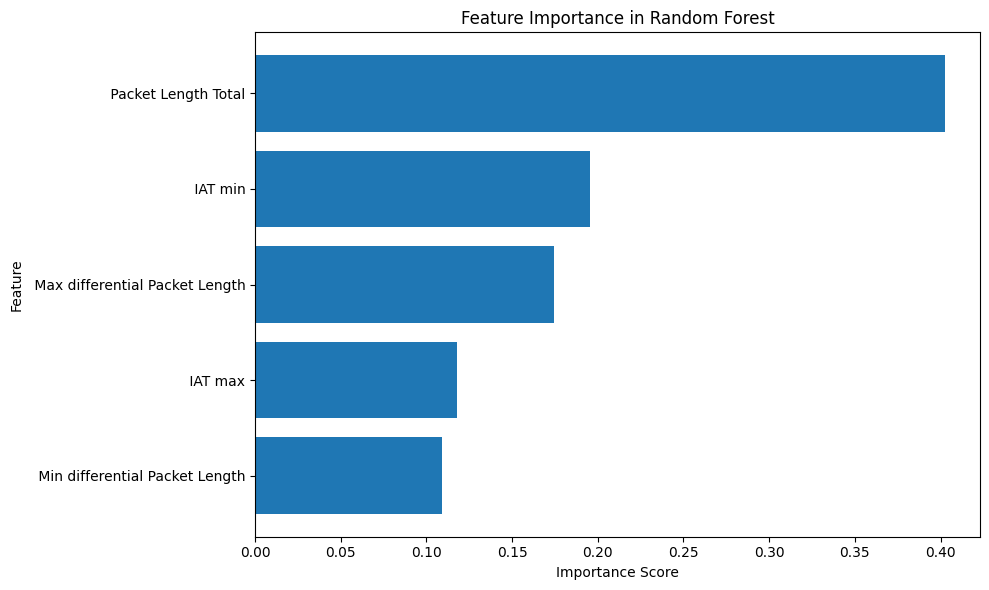

                                       0
Packet Length Total             0.288332
Max differential Packet Length  0.256911
IAT min                         0.181399
IAT max                         0.138452
Min differential Packet Length  0.134907


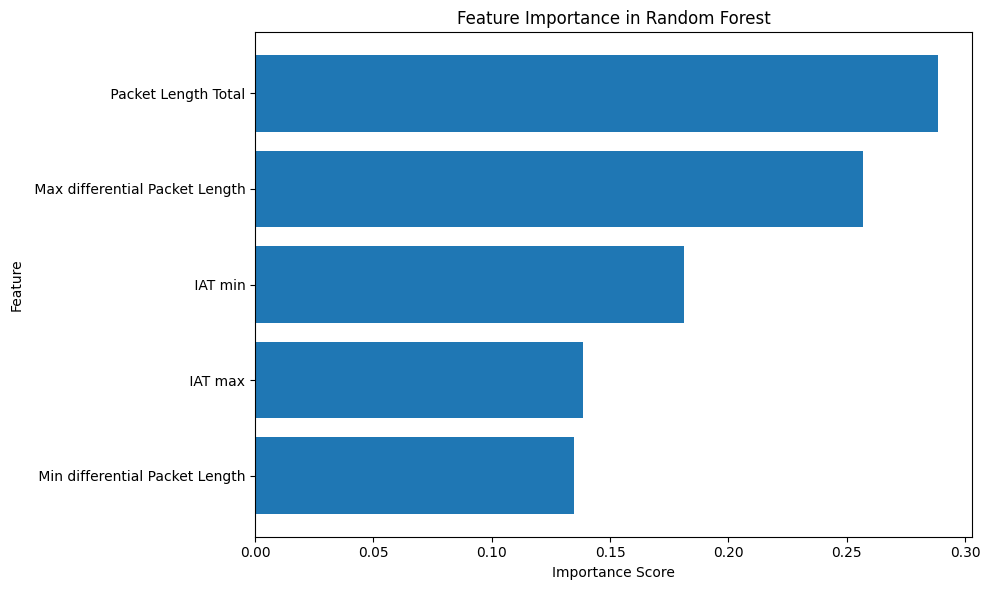

                                       0
Max differential Packet Length  0.277198
Packet Length Total             0.273850
IAT min                         0.174216
Min differential Packet Length  0.140775
IAT max                         0.133961


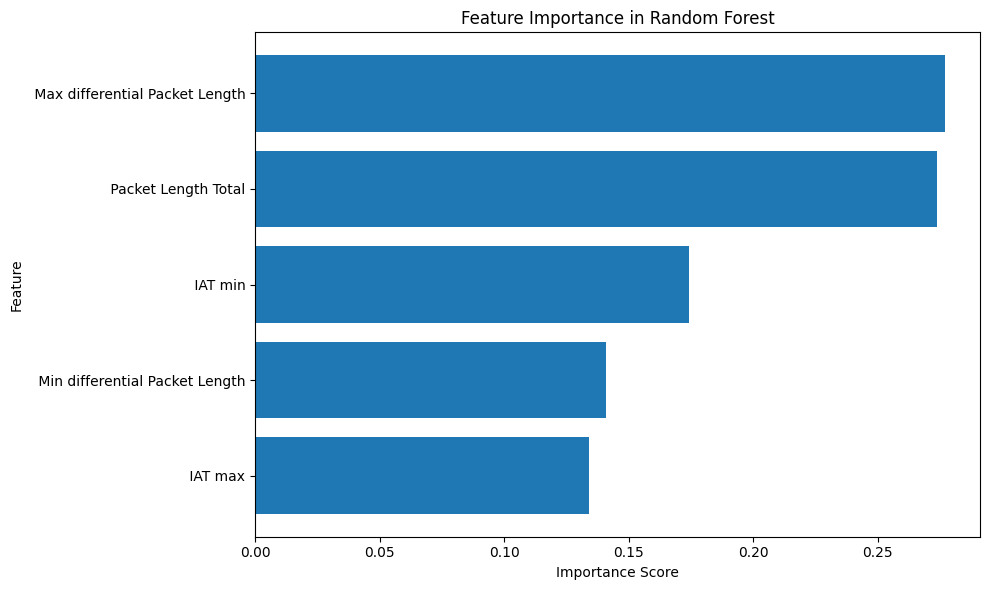

                                       0
Packet Length Total             0.347649
IAT min                         0.200586
Max differential Packet Length  0.199502
IAT max                         0.146499
Min differential Packet Length  0.105764


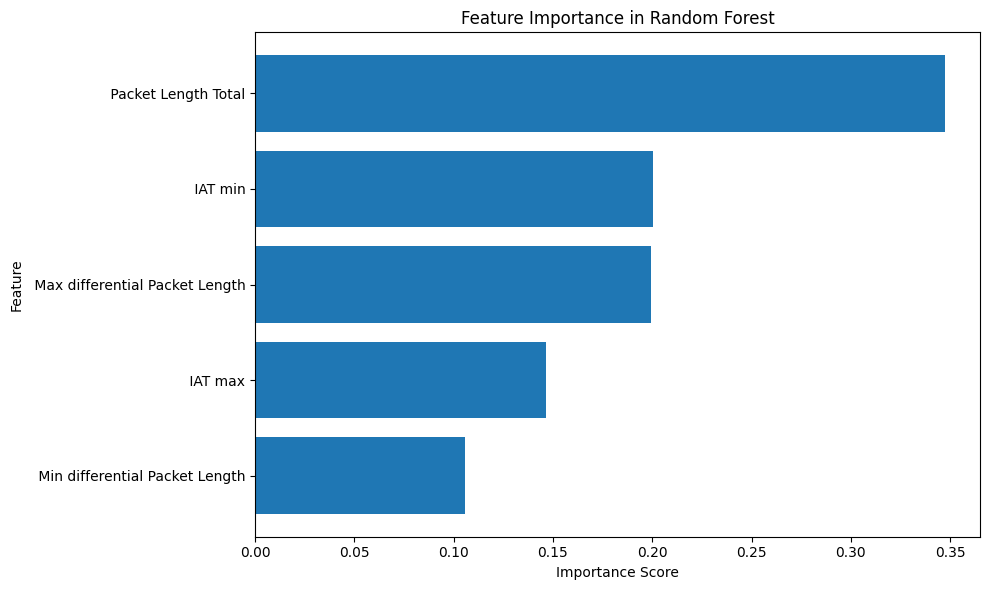

                                       0
Packet Length Total             0.279856
Max differential Packet Length  0.275779
IAT min                         0.179590
IAT max                         0.139443
Min differential Packet Length  0.125332


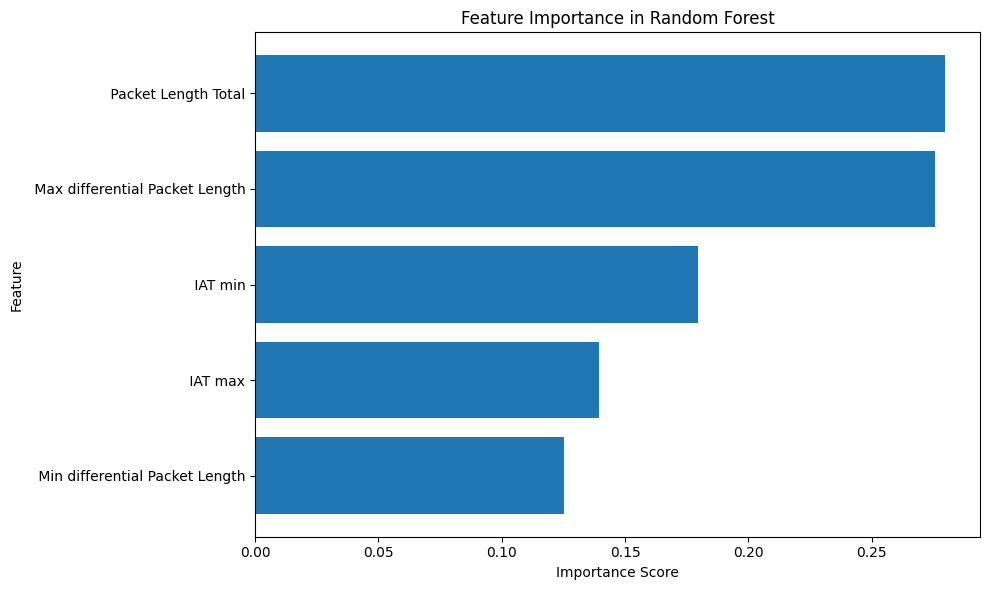

                                       0
Max differential Packet Length  0.284796
Packet Length Total             0.275324
IAT min                         0.173011
Min differential Packet Length  0.135184
IAT max                         0.131685


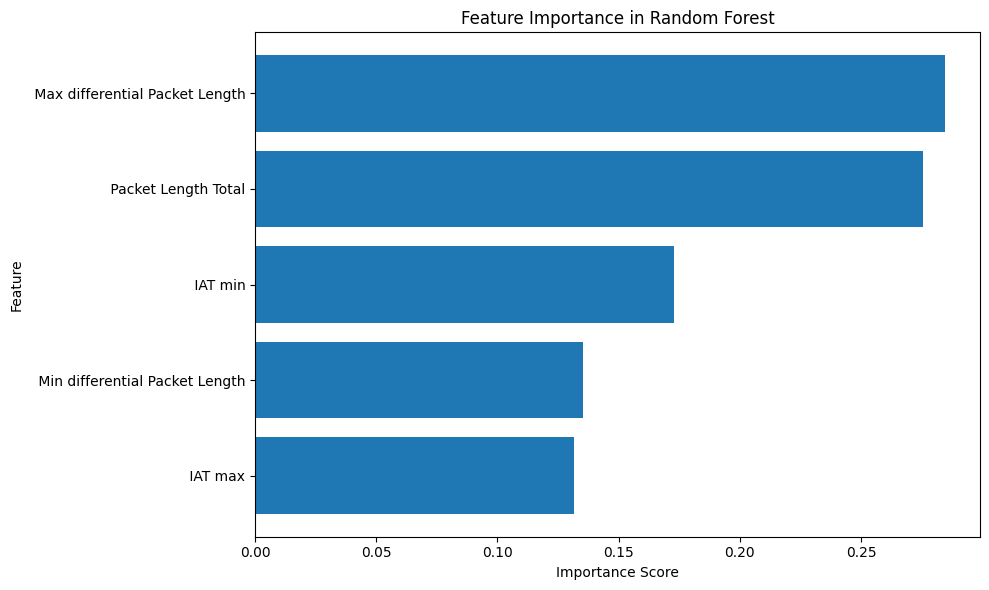

                                       0
Packet Length Total             0.358314
IAT min                         0.203399
Max differential Packet Length  0.195877
IAT max                         0.140095
Min differential Packet Length  0.102315


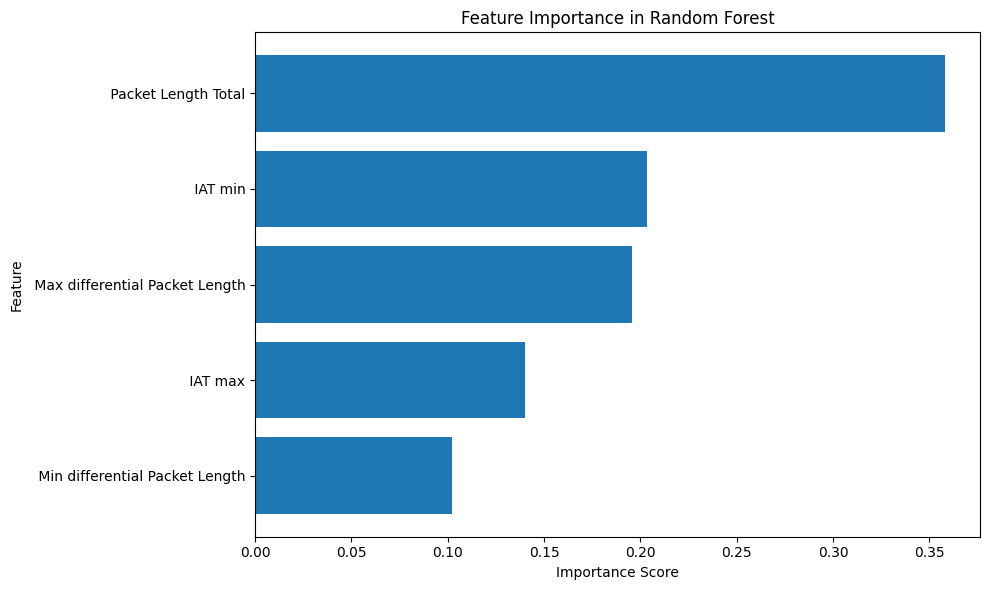

                                       0
Packet Length Total             0.288873
Max differential Packet Length  0.270740
IAT min                         0.178512
IAT max                         0.138979
Min differential Packet Length  0.122895


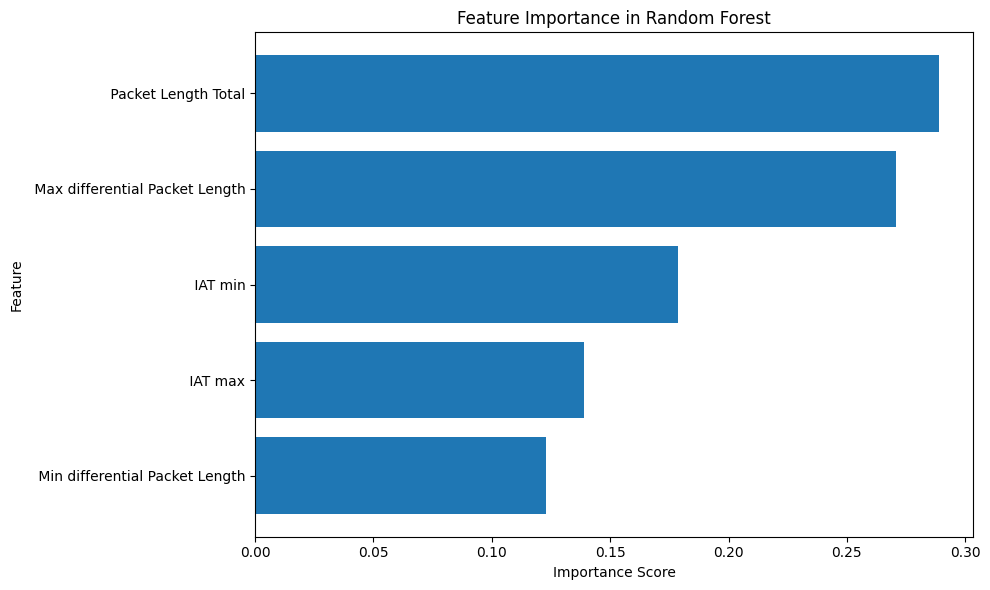

                                       0
Max differential Packet Length  0.283286
Packet Length Total             0.278494
IAT min                         0.174676
IAT max                         0.134468
Min differential Packet Length  0.129076


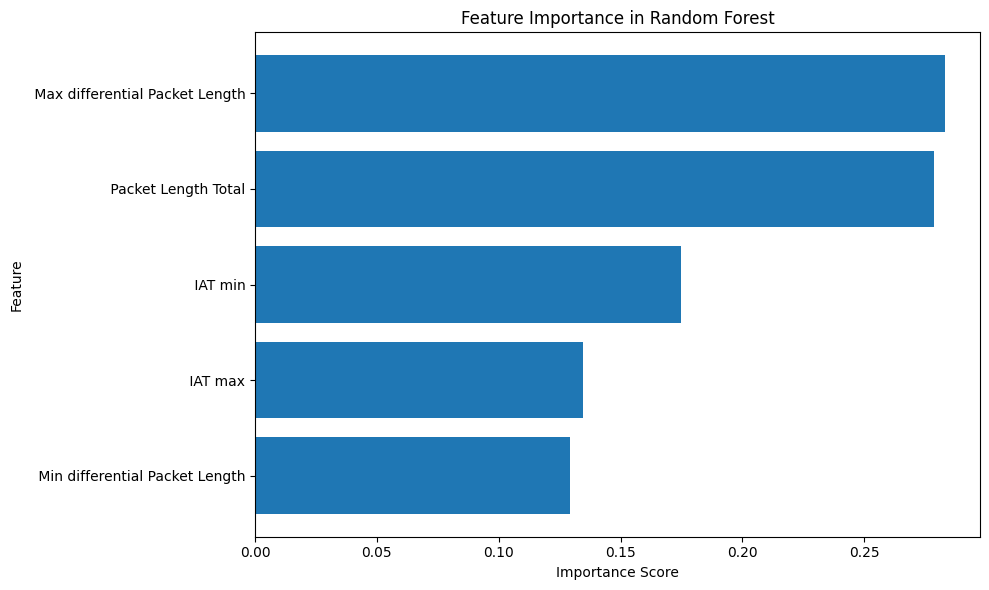

                                       0
Packet Length Total             0.361141
Max differential Packet Length  0.220127
IAT min                         0.198772
IAT max                         0.121764
Min differential Packet Length  0.098196


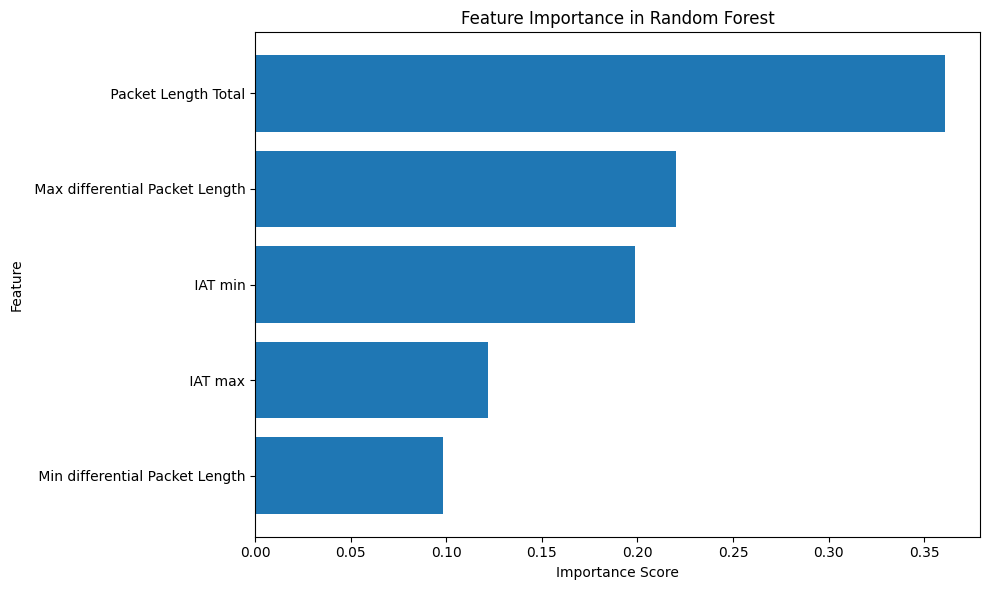

                                       0
Max differential Packet Length  0.284820
Packet Length Total             0.280489
IAT min                         0.179384
IAT max                         0.133545
Min differential Packet Length  0.121762


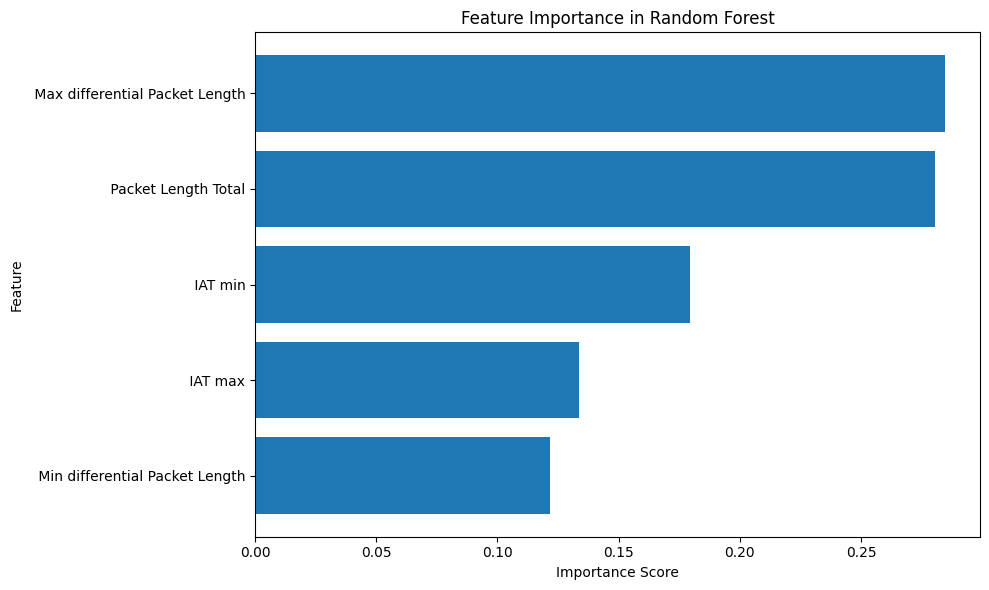

                                       0
Max differential Packet Length  0.295717
Packet Length Total             0.272287
IAT min                         0.174372
IAT max                         0.131249
Min differential Packet Length  0.126375


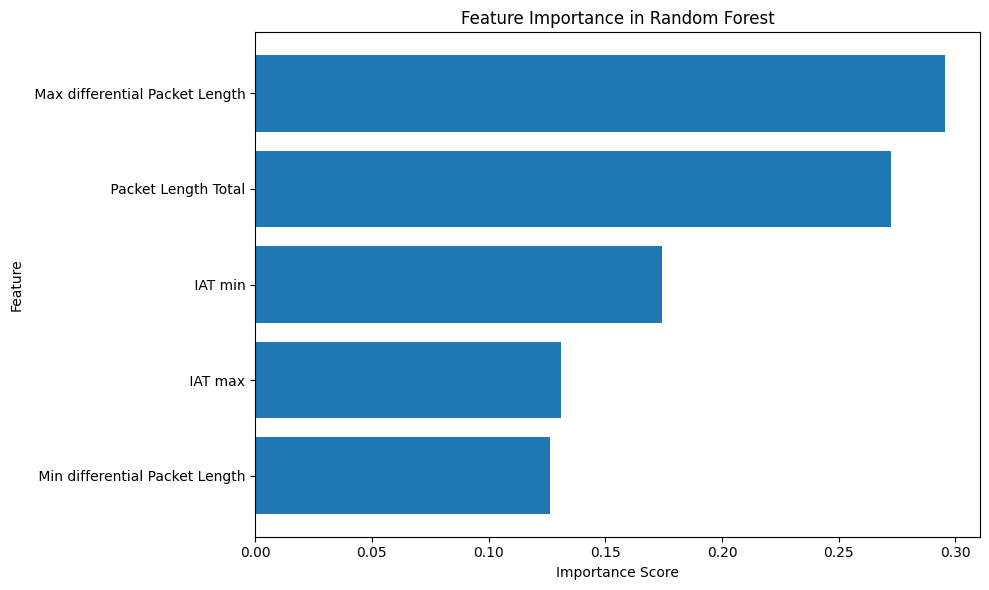

                                       0
Packet Length Total             0.350921
Max differential Packet Length  0.220075
IAT min                         0.191734
IAT max                         0.137570
Min differential Packet Length  0.099700


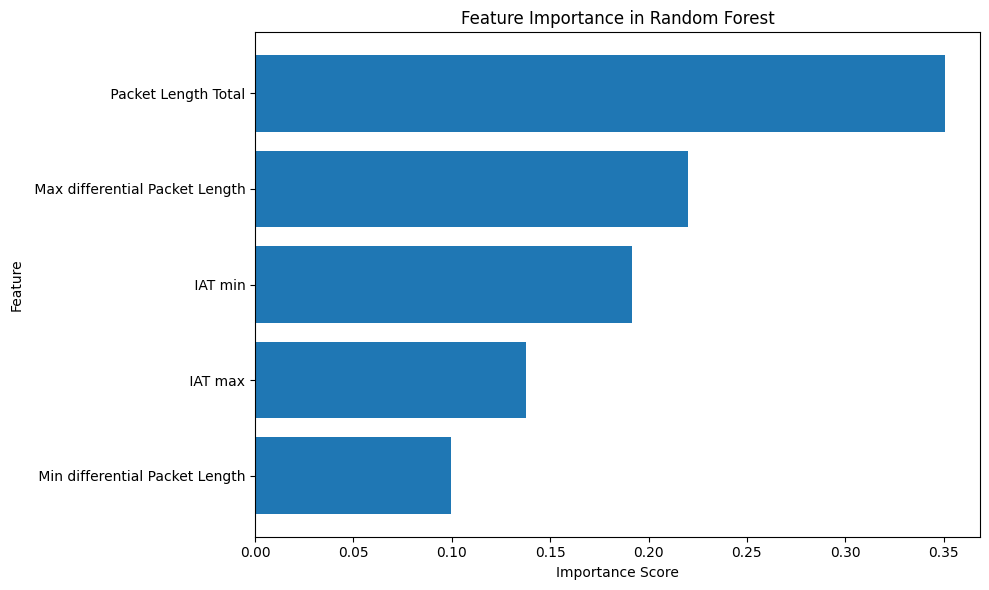

                                       0
Packet Length Total             0.286183
Max differential Packet Length  0.282240
IAT min                         0.174558
IAT max                         0.138715
Min differential Packet Length  0.118304


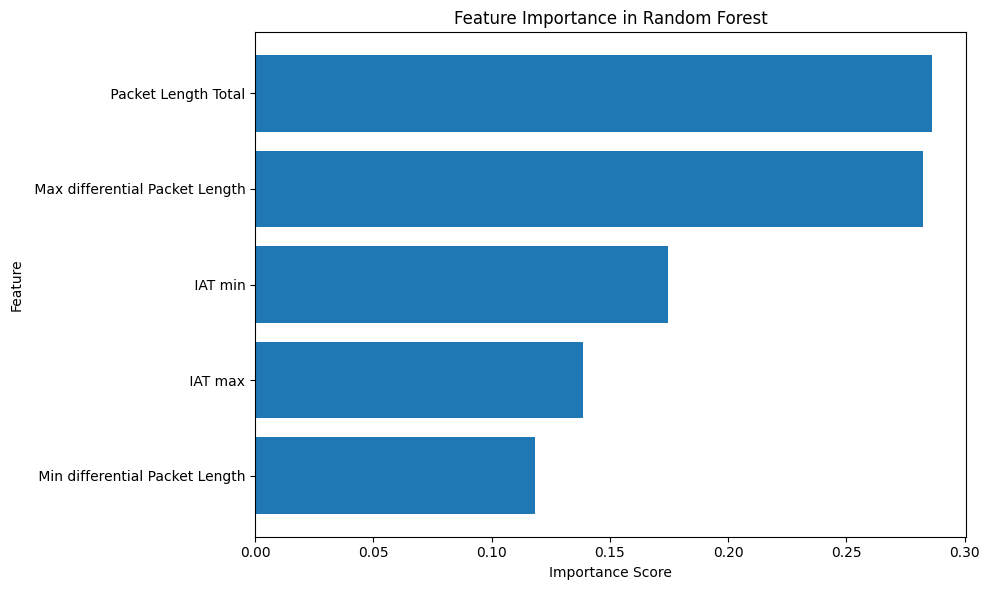

                                       0
Max differential Packet Length  0.294202
Packet Length Total             0.274219
IAT min                         0.169978
IAT max                         0.135838
Min differential Packet Length  0.125763


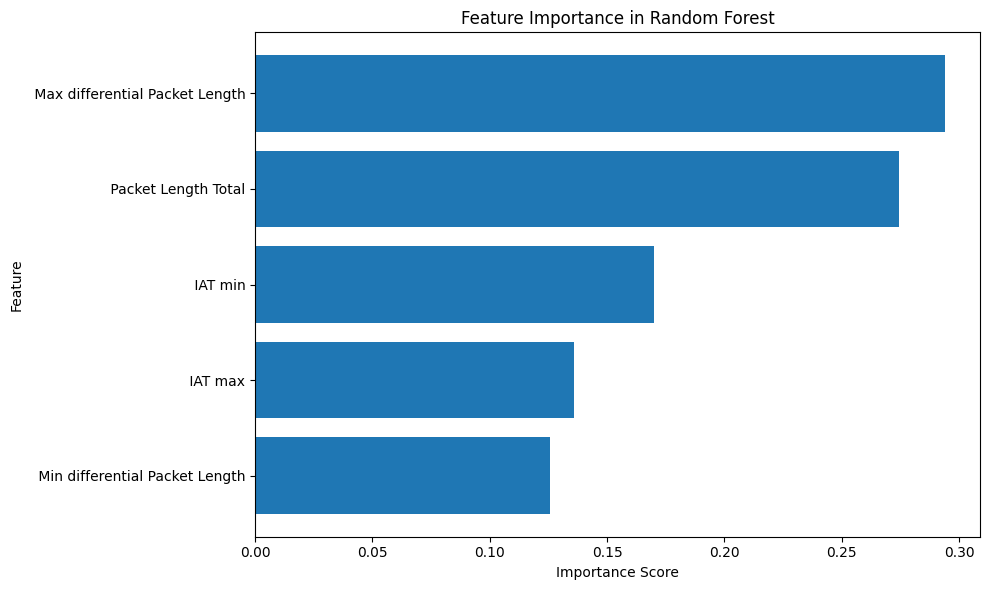

                                       0
Packet Length Total             0.355138
Max differential Packet Length  0.226139
IAT min                         0.186606
IAT max                         0.132204
Min differential Packet Length  0.099913


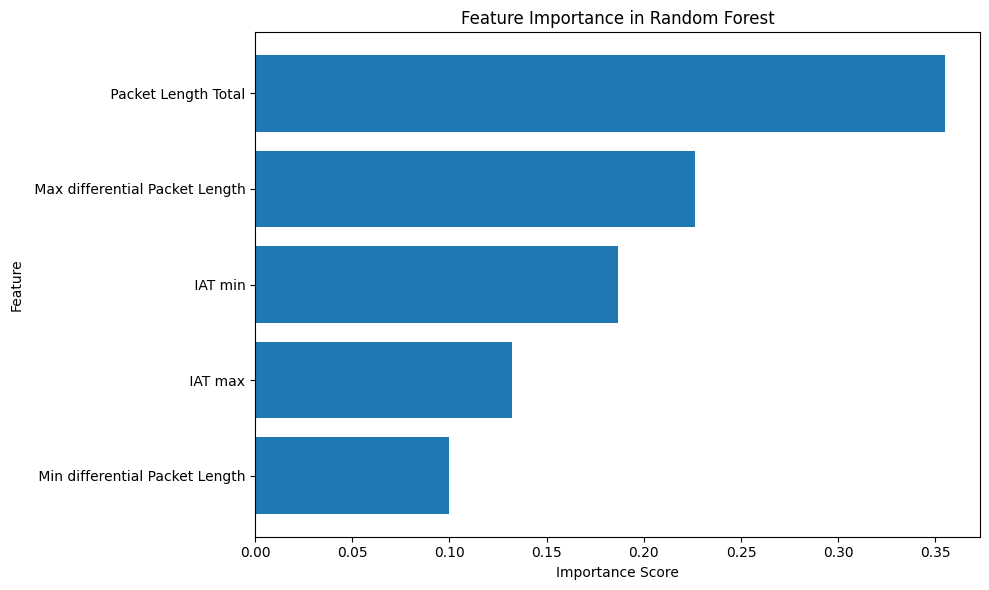

                                       0
Max differential Packet Length  0.282472
Packet Length Total             0.282443
IAT min                         0.172809
IAT max                         0.139579
Min differential Packet Length  0.122697


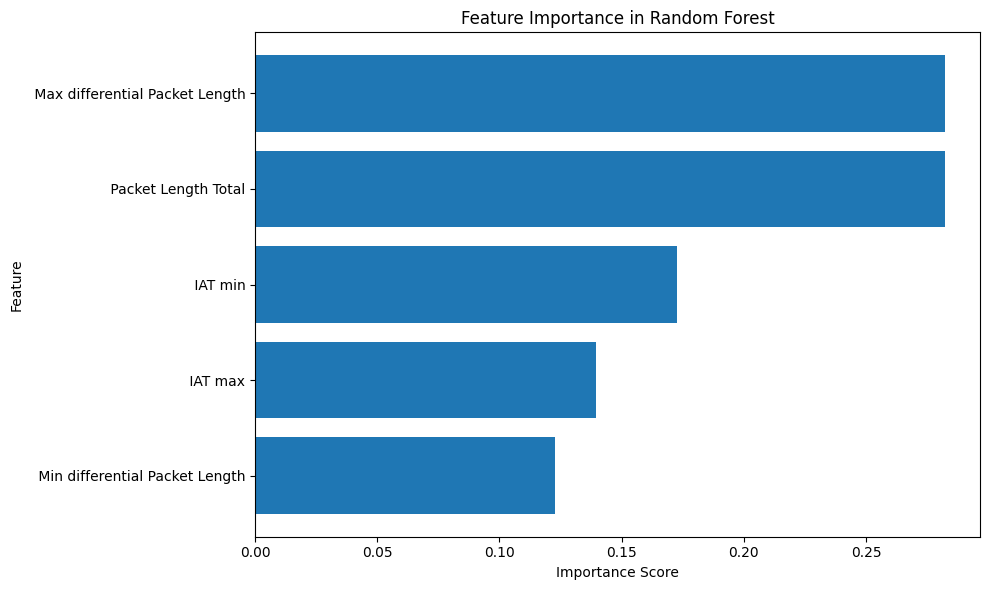

                                       0
Max differential Packet Length  0.289915
Packet Length Total             0.277424
IAT min                         0.171718
IAT max                         0.133742
Min differential Packet Length  0.127202


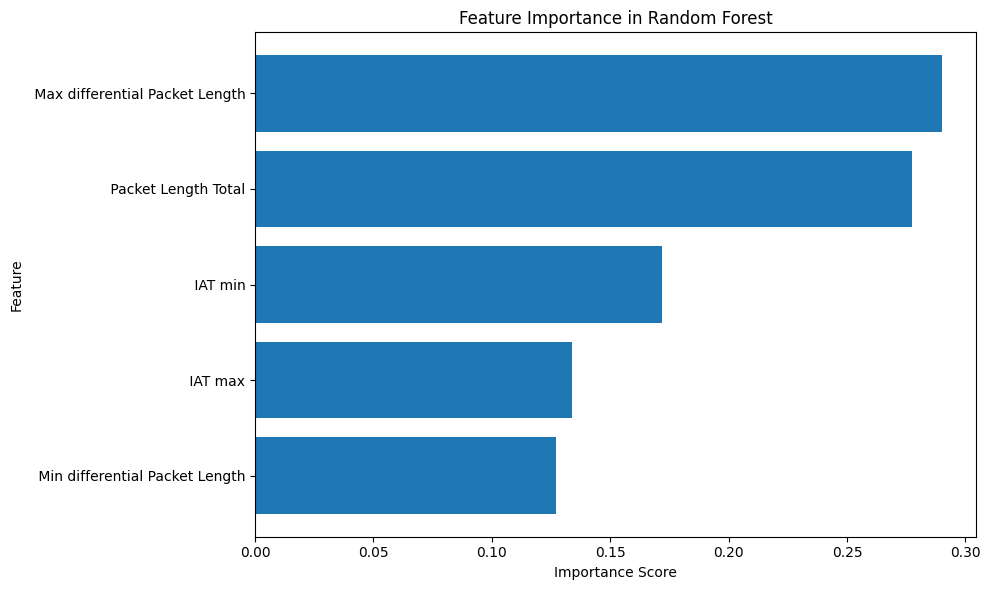

                                       0
Packet Length Total             0.346513
Max differential Packet Length  0.230230
IAT min                         0.188010
IAT max                         0.134536
Min differential Packet Length  0.100711


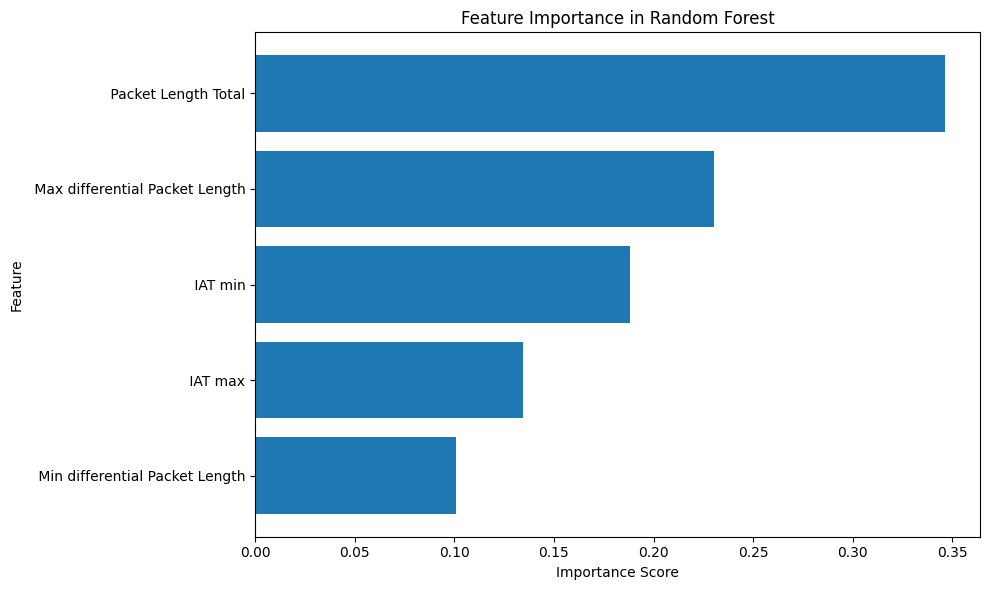

                                       0
Packet Length Total             0.286794
Max differential Packet Length  0.283389
IAT min                         0.170967
IAT max                         0.139426
Min differential Packet Length  0.119425


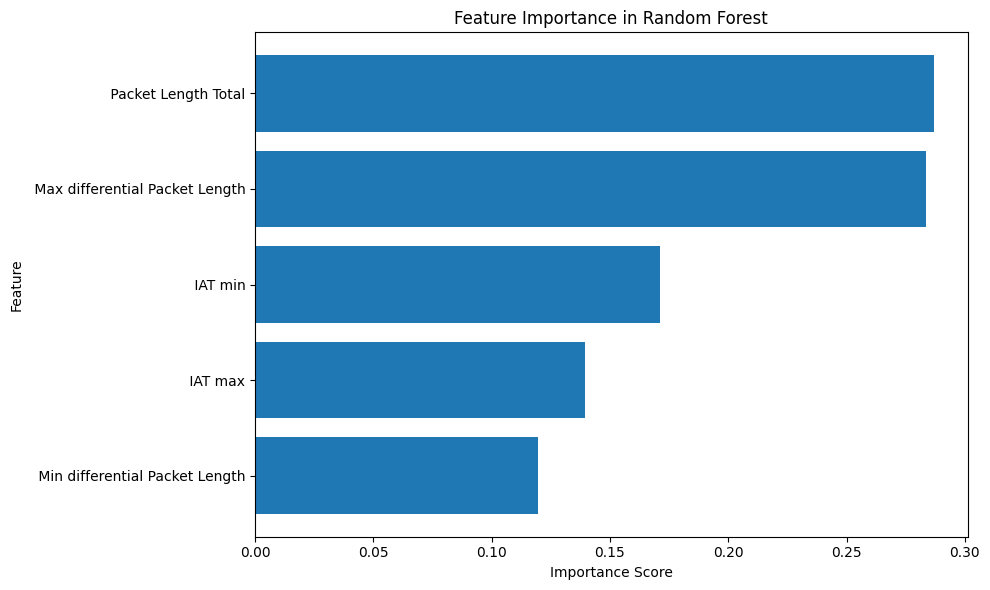

                                       0
Max differential Packet Length  0.292204
Packet Length Total             0.278851
IAT min                         0.169910
IAT max                         0.135853
Min differential Packet Length  0.123182


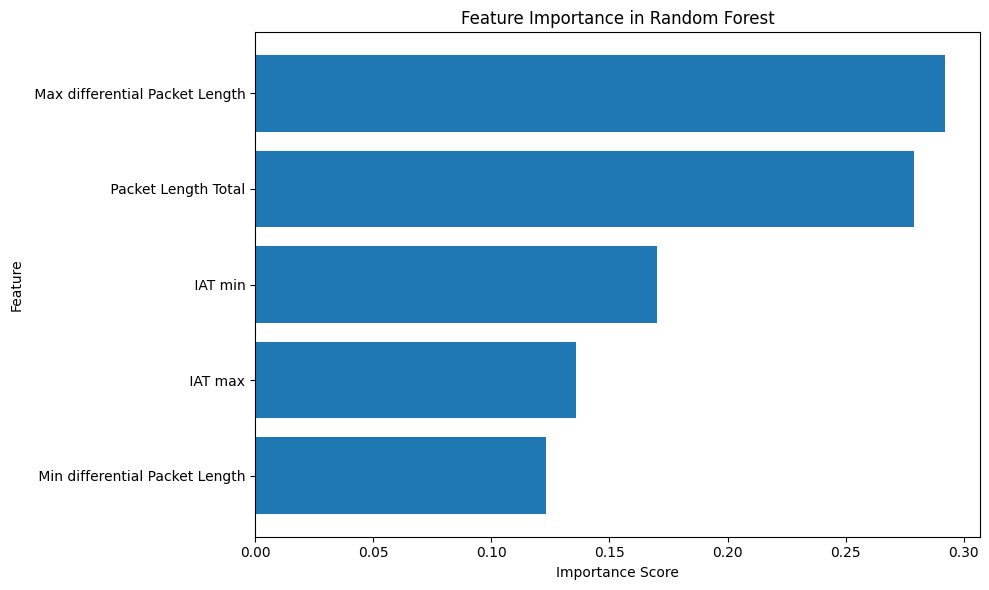

                                       0
Packet Length Total             0.345615
Max differential Packet Length  0.232545
IAT min                         0.195565
IAT max                         0.127178
Min differential Packet Length  0.099098


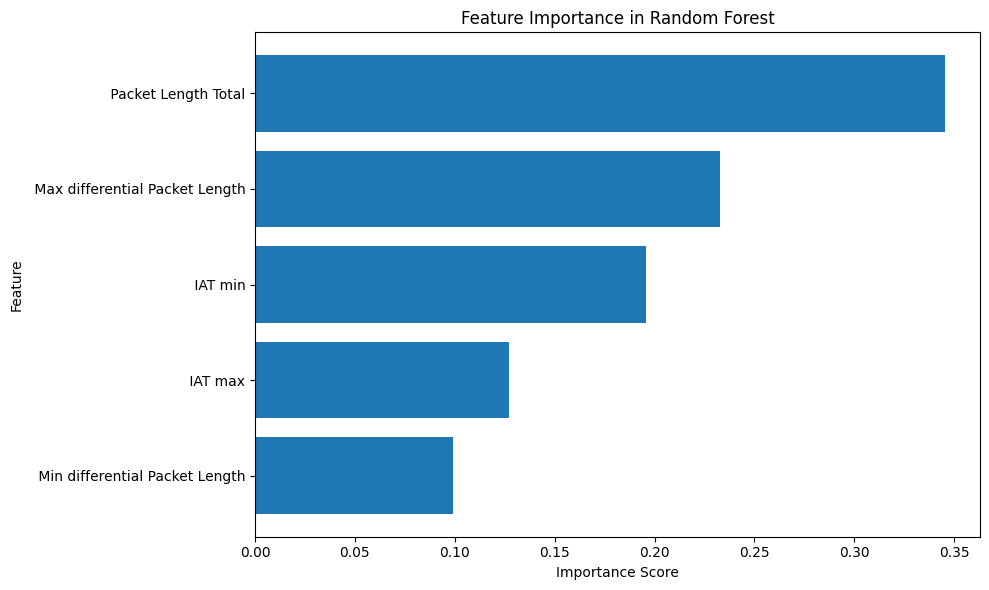

                                       0
Packet Length Total             0.286524
Max differential Packet Length  0.282796
IAT min                         0.172603
IAT max                         0.138990
Min differential Packet Length  0.119086


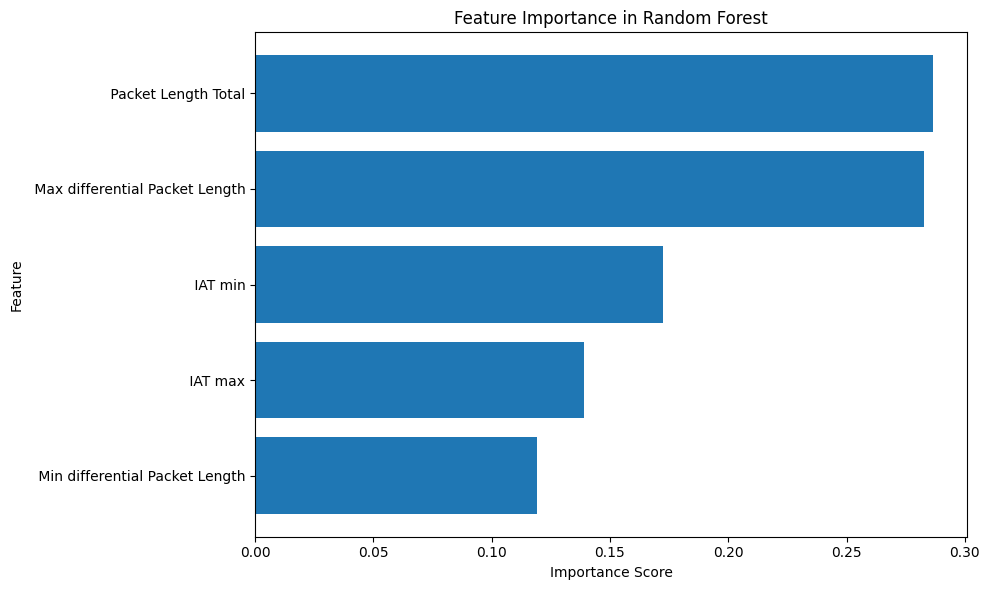

                                       0
Max differential Packet Length  0.290871
Packet Length Total             0.277023
IAT min                         0.170849
IAT max                         0.138006
Min differential Packet Length  0.123250


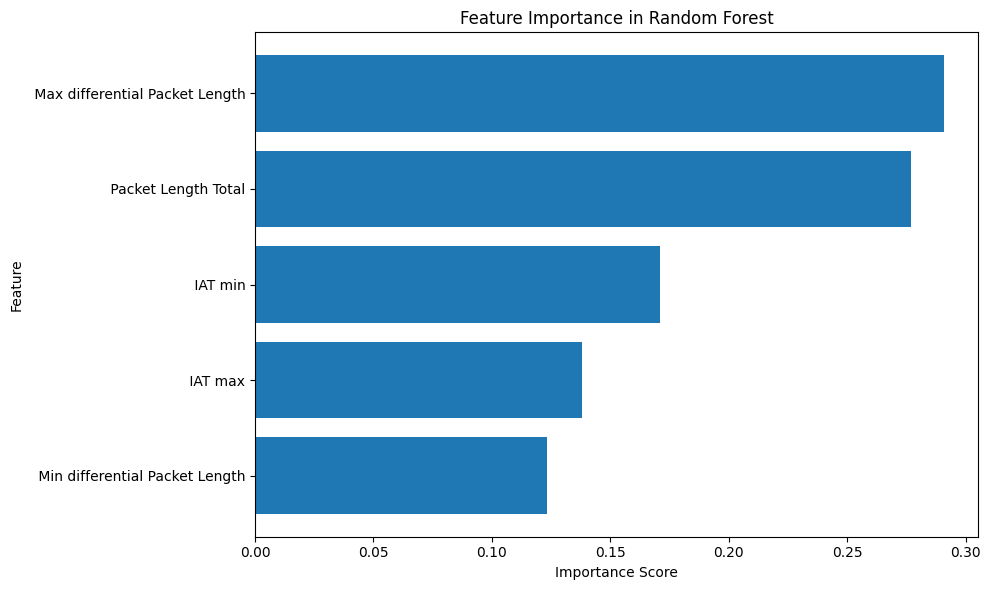

                                       0
Packet Length Total             0.351047
Max differential Packet Length  0.225685
IAT min                         0.188161
IAT max                         0.134804
Min differential Packet Length  0.100303


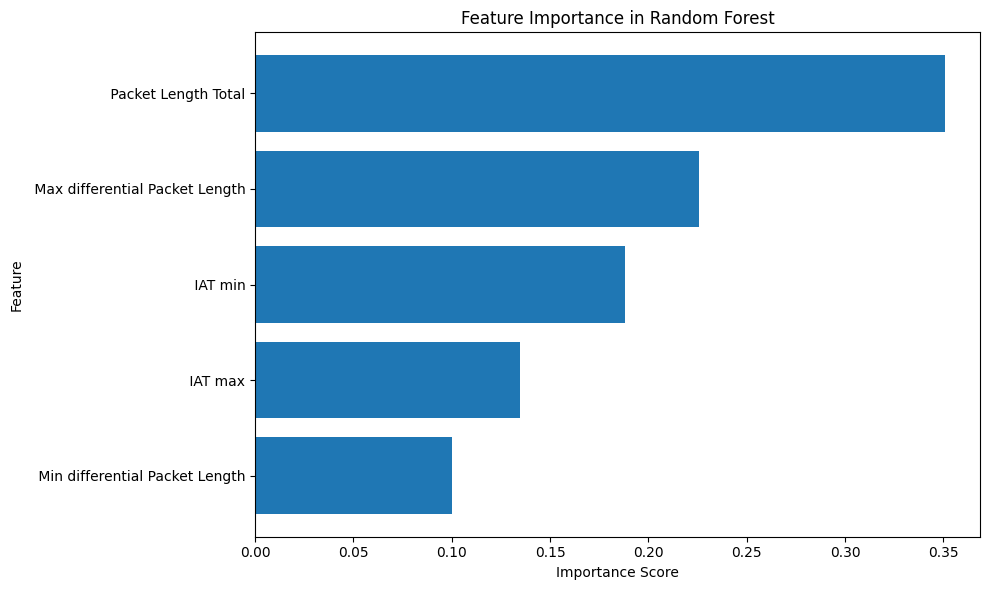

                                       0
Packet Length Total             0.286834
Max differential Packet Length  0.280540
IAT min                         0.169733
IAT max                         0.143759
Min differential Packet Length  0.119133


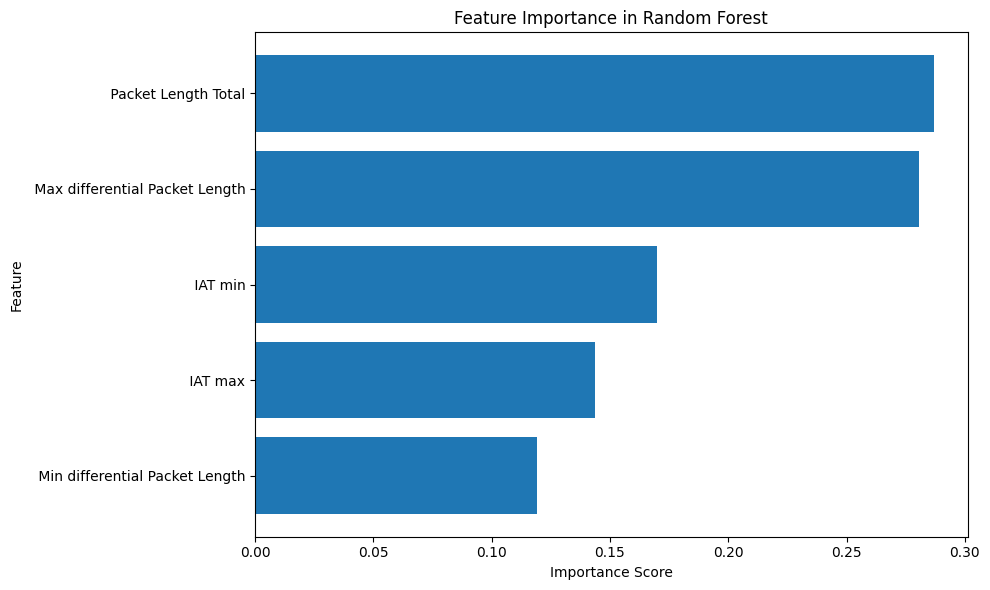

                                       0
Max differential Packet Length  0.290507
Packet Length Total             0.278106
IAT min                         0.169024
IAT max                         0.139445
Min differential Packet Length  0.122918


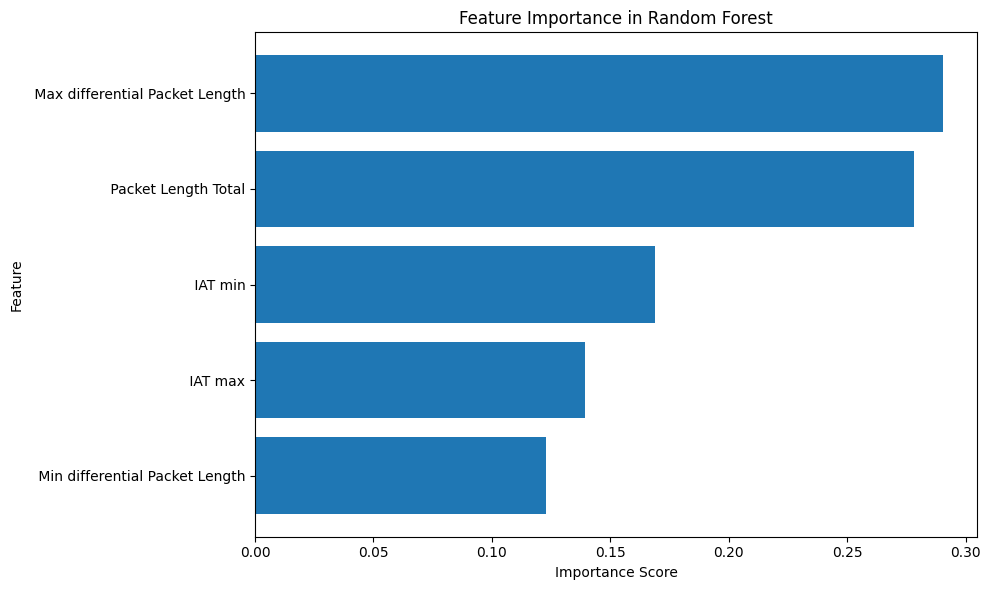

                                       0
Packet Length Total             0.347639
Max differential Packet Length  0.234049
IAT min                         0.192547
IAT max                         0.126559
Min differential Packet Length  0.099207


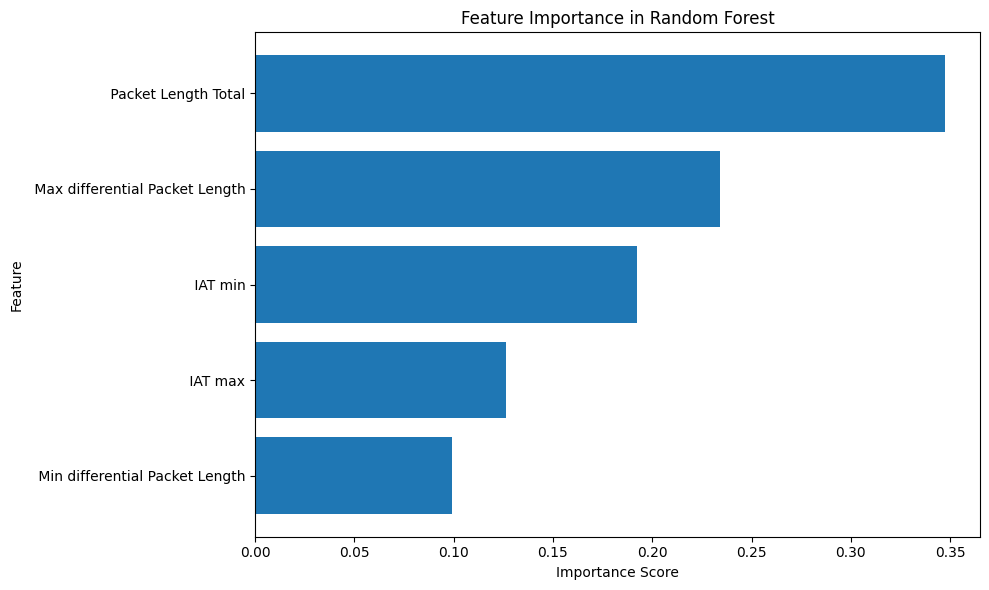

                                       0
Packet Length Total             0.289996
Max differential Packet Length  0.281996
IAT min                         0.171920
IAT max                         0.137172
Min differential Packet Length  0.118916


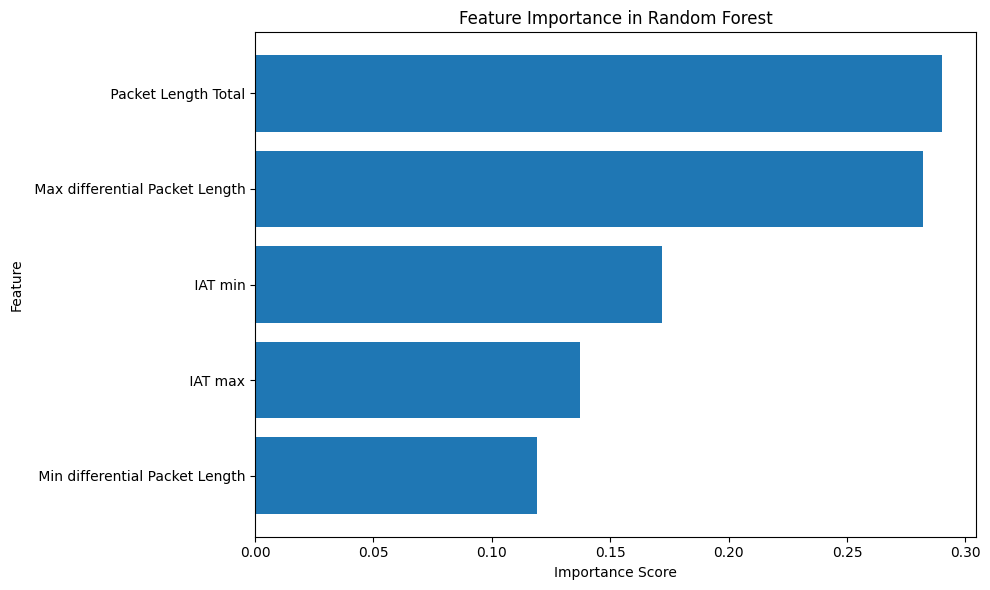

                                       0
Max differential Packet Length  0.289657
Packet Length Total             0.281555
IAT min                         0.169380
IAT max                         0.136567
Min differential Packet Length  0.122841


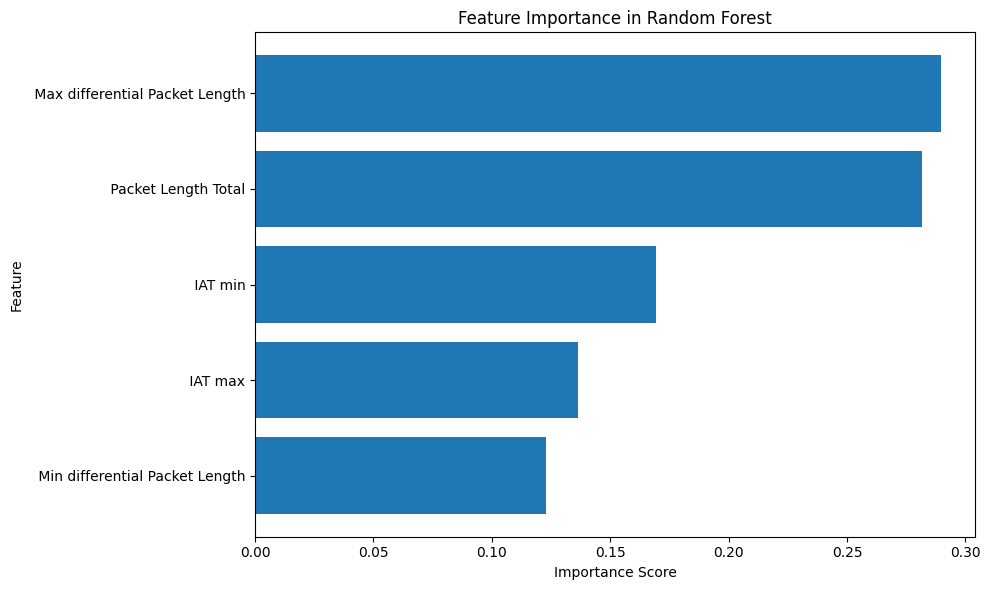

                                       0
Packet Length Total             0.354309
Max differential Packet Length  0.226525
IAT min                         0.191191
IAT max                         0.129337
Min differential Packet Length  0.098639


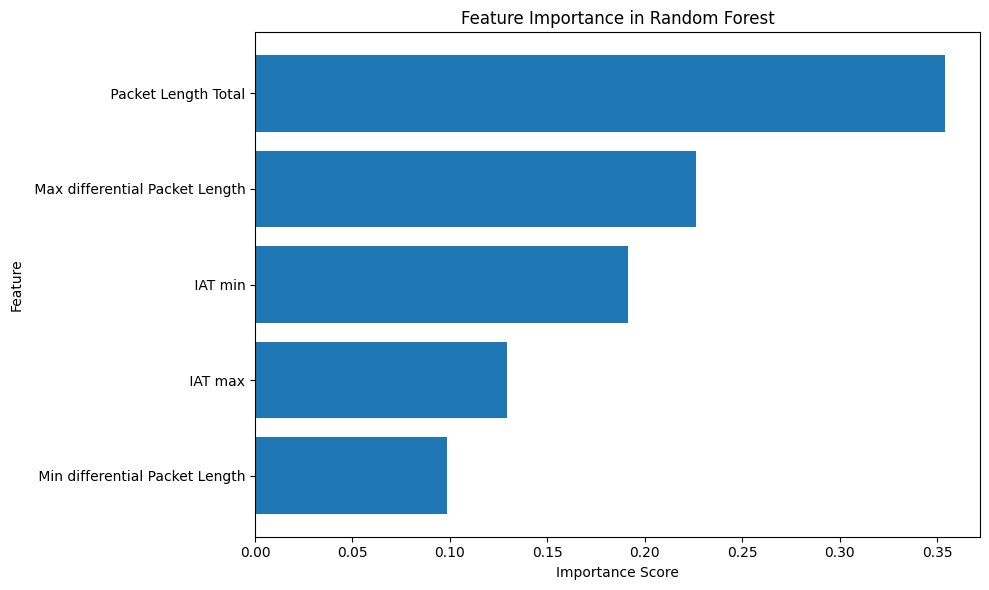

                                       0
Packet Length Total             0.292365
Max differential Packet Length  0.278469
IAT min                         0.171921
IAT max                         0.139874
Min differential Packet Length  0.117372


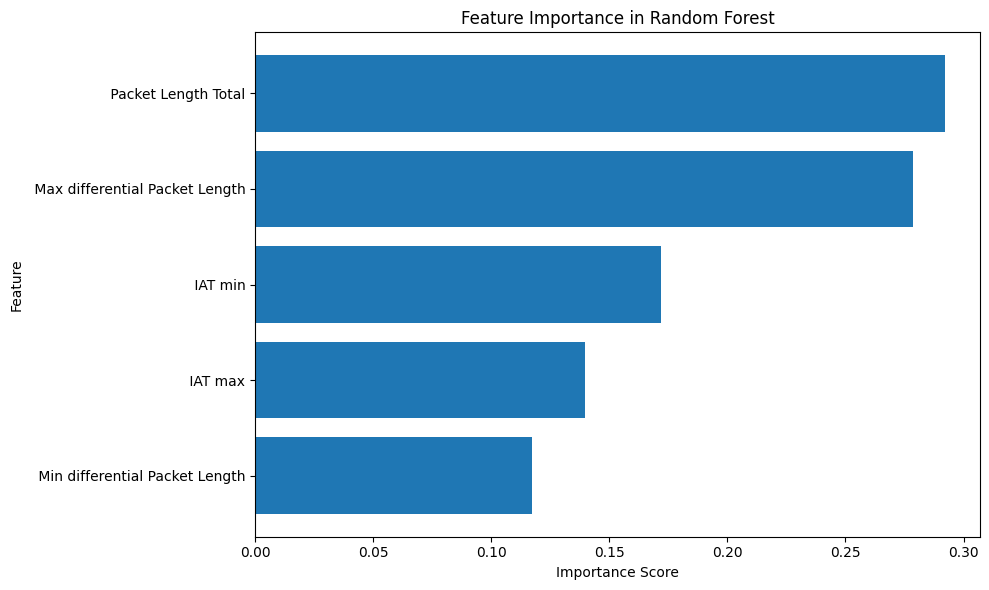

                                       0
Max differential Packet Length  0.289652
Packet Length Total             0.281543
IAT min                         0.169692
IAT max                         0.137640
Min differential Packet Length  0.121473


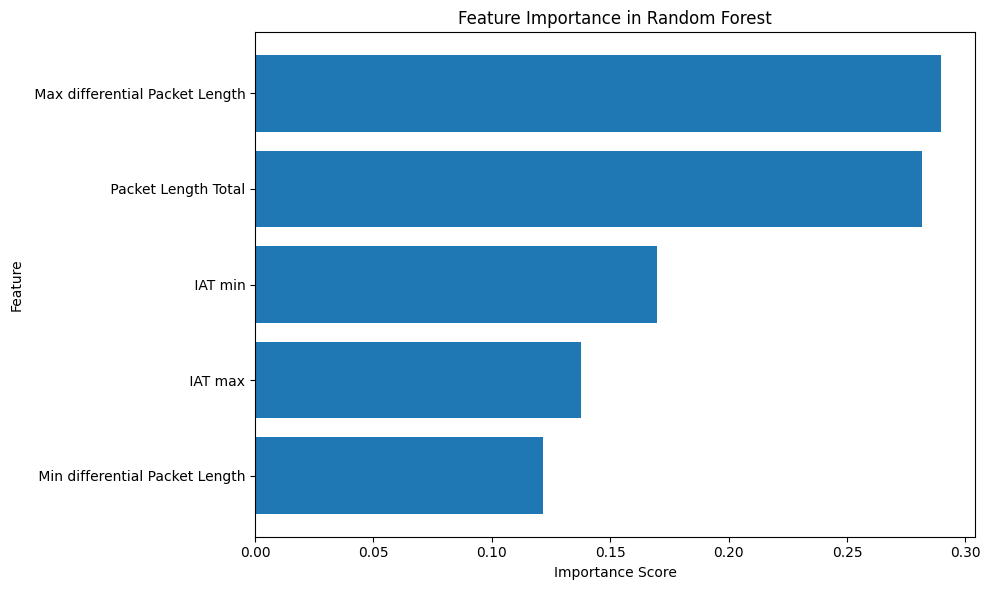

                                       0
Packet Length Total             0.355939
Max differential Packet Length  0.226973
IAT min                         0.190340
IAT max                         0.128055
Min differential Packet Length  0.098693


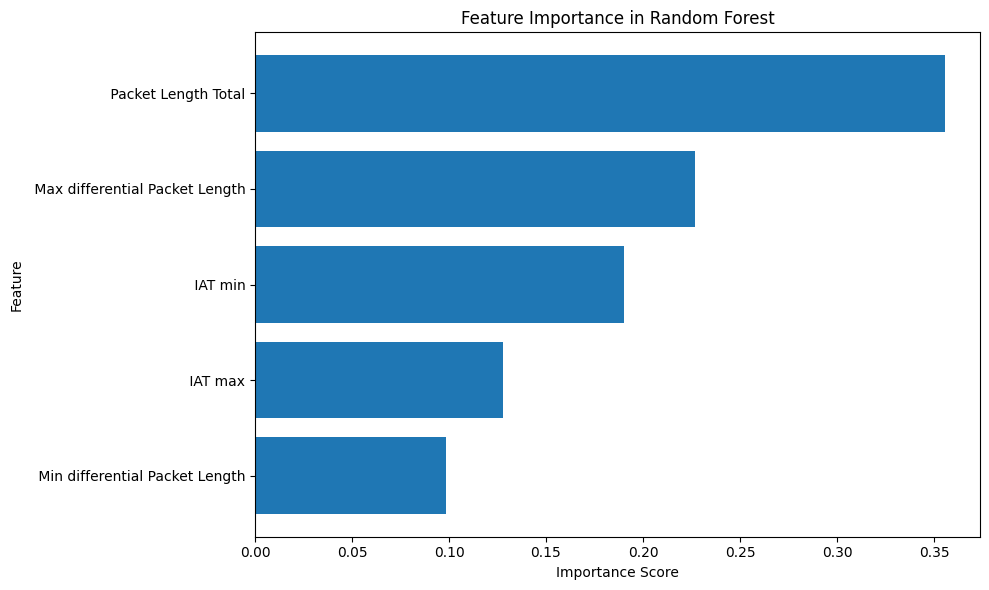

                                       0
Packet Length Total             0.291889
Max differential Packet Length  0.280353
IAT min                         0.170273
IAT max                         0.139530
Min differential Packet Length  0.117955


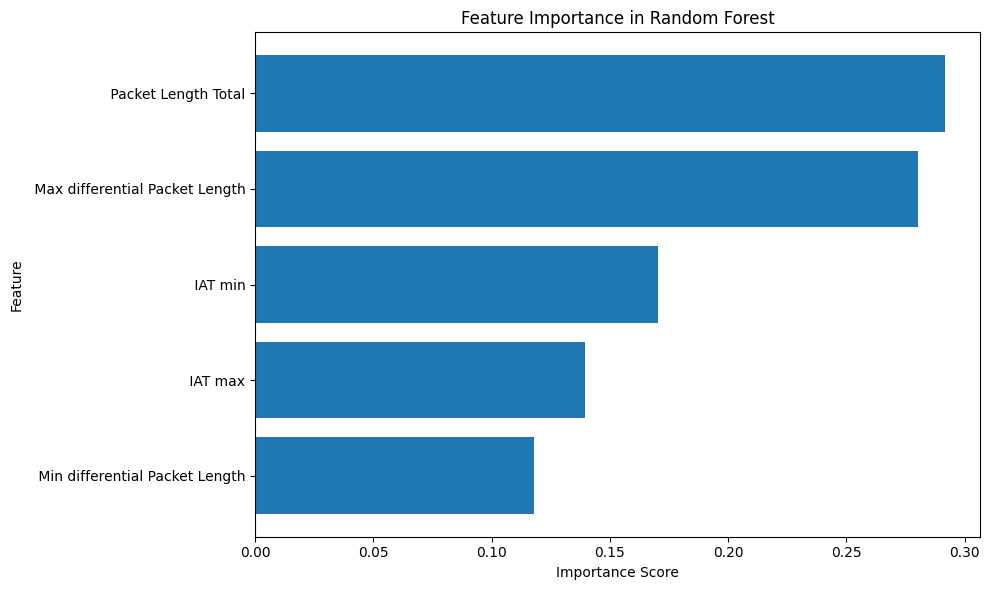

                                       0
Max differential Packet Length  0.291139
Packet Length Total             0.280564
IAT min                         0.169586
IAT max                         0.136942
Min differential Packet Length  0.121769


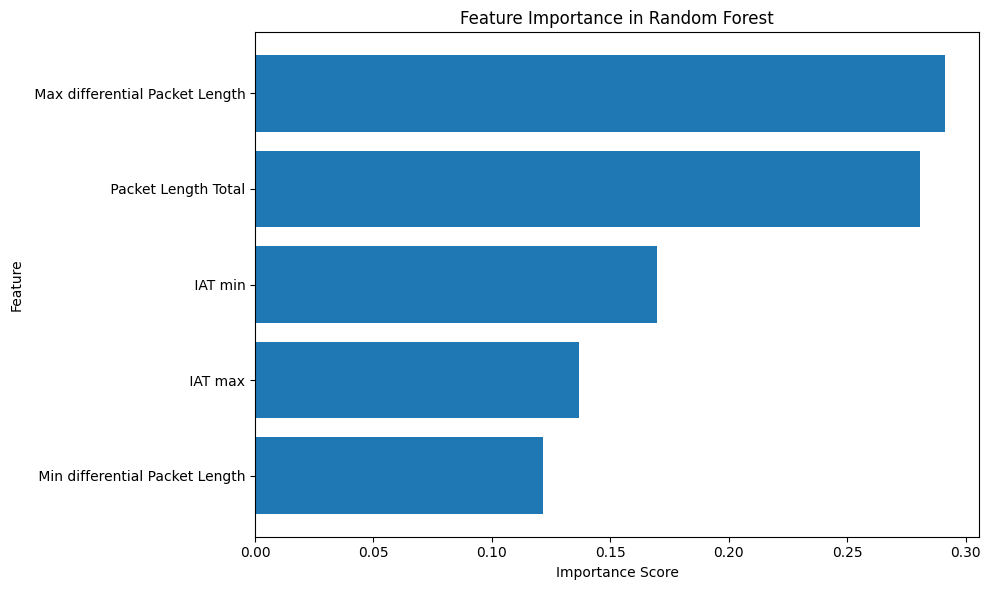

                                       0
Packet Length Total             0.348892
Max differential Packet Length  0.235479
IAT min                         0.188813
IAT max                         0.129595
Min differential Packet Length  0.097220


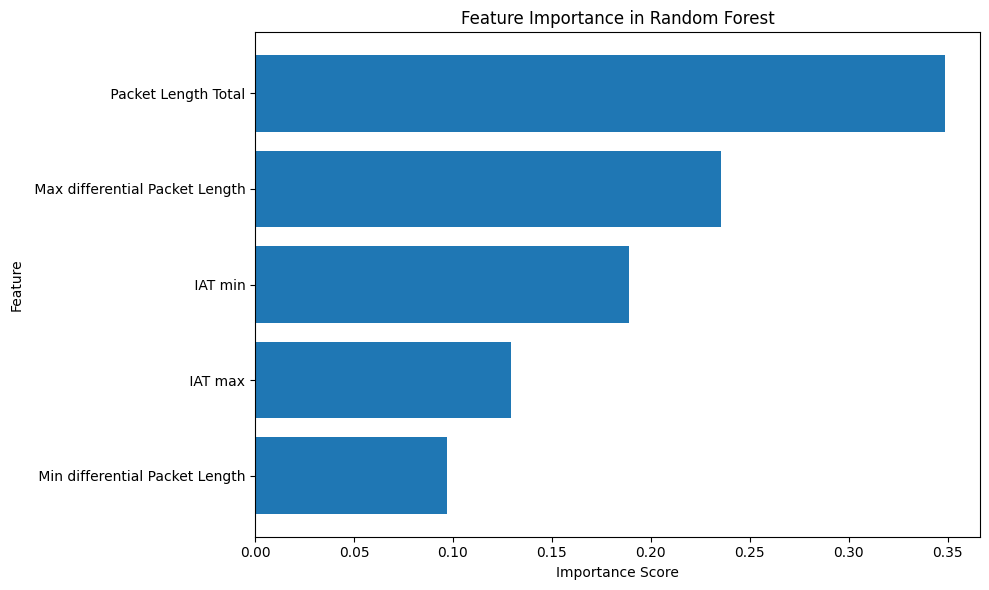

                                       0
Packet Length Total             0.290157
Max differential Packet Length  0.282333
IAT min                         0.170849
IAT max                         0.139323
Min differential Packet Length  0.117338


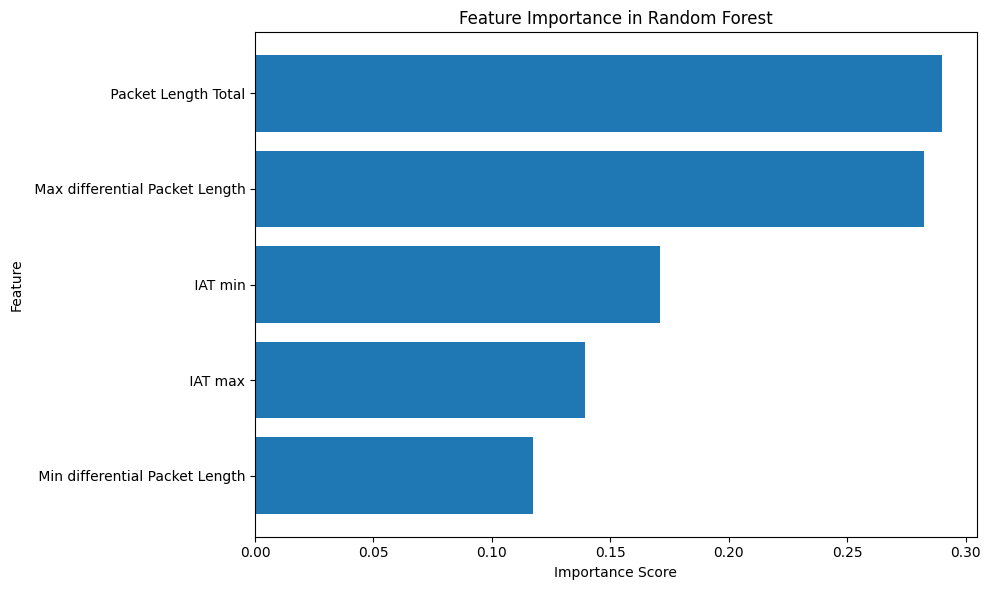

                                       0
Max differential Packet Length  0.291729
Packet Length Total             0.280242
IAT min                         0.169879
IAT max                         0.136677
Min differential Packet Length  0.121472


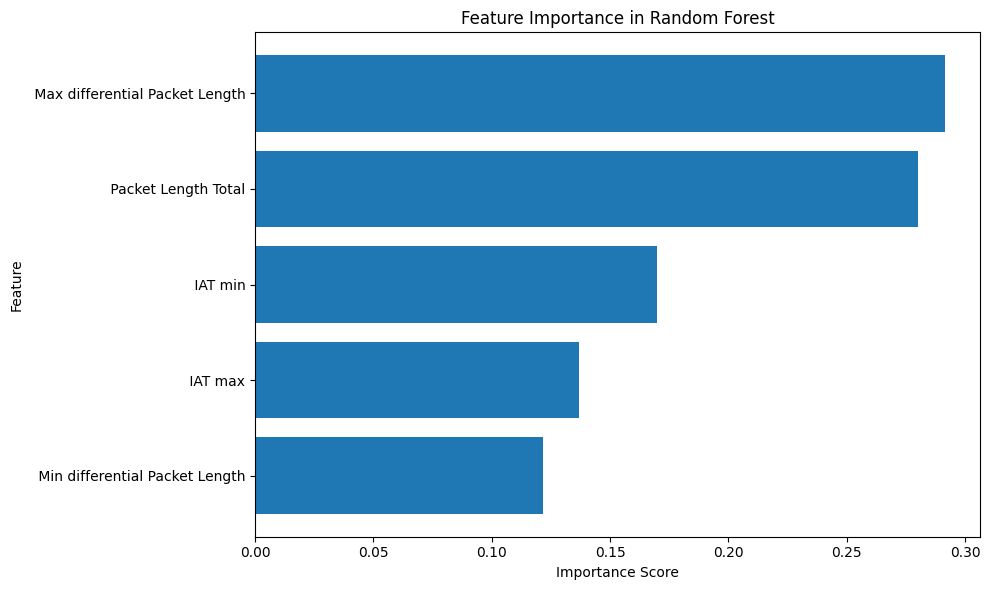

Analysis Complete. Check output file.


[]

In [11]:
# Get X and y for train and test
X_train, y_train = extract_x_y(train_data, class_numbers, features)
X_test,  y_test  = extract_x_y(test_data, class_numbers, features)

param_grid_rf = {
    "n_estimators": [1, 3, 5, 6],
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier()

# GridSearchCV for hyperparameter tuning
cv_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1)
cv_rf.fit(X_train, y_train)

best_rf_estimator = cv_rf.best_estimator_
print(f"Best Random Forest Model: {best_rf_estimator}")

# analyze the models
analyze_models(class_numbers, "RF", range(8,21,1), range(1,6,2), X_train, y_train, X_test, y_test, 1000, "/content/drive/MyDrive/Colab Notebooks/random_forest/Input_models.json")

In [12]:
cv_rf.score(X_test,y_test)
cv_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 6}

### Feature engineering

In [13]:
features_t = [' Min differential Packet Length', ' Max differential Packet Length', ' IAT min', ' IAT max', ' Packet Length Total']

In [14]:
X_train, y_train = extract_x_y(train_data, class_numbers, features_t)

X_test,  y_test  = extract_x_y(test_data, class_numbers, features_t)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [15]:
# Confirm scores of selected model
model = RandomForestClassifier(criterion="entropy", max_depth=20, n_estimators = 3, max_leaf_nodes=64, n_jobs=4, random_state=42, bootstrap=False, class_weight='balanced')

model.fit(X_train_res[features_t], y_train_res)

# Evaluate the model
evaluate_model_overfitting(model, X_train_res, y_train_res, X_test, y_test)

y_pred = model.predict(X_test[features_t])

class_report = classification_report(y_test, y_pred, target_names=class_numbers, output_dict = True)

print(classification_report)

macro_score = class_report['macro avg']['f1-score']
weighted_score = class_report['weighted avg']['f1-score']

print("Macro Score: ", macro_score)
print("Weighted Score: ", weighted_score)

df = pd.DataFrame(class_report).transpose()

df

Train Accuracy: 0.9086047158932761
Test Accuracy: 0.8931945674638323
Performance Difference: 0.01541014842944377
Evaluation: The model has a good balance between training and testing performance.
<function classification_report at 0x7a3c65571080>
Macro Score:  0.8856812502774991
Weighted Score:  0.8947930779489764


,precision,recall,f1-score,support
discord,0.845345,0.902244,0.872868,1872.000000
whatsapp,0.846702,0.977366,0.907354,486.000000
signal,0.988806,0.925764,0.956247,2290.000000
telegram,0.734234,0.864721,0.794153,1885.000000
messenger,0.927774,0.810143,0.864977,1538.000000
teams,0.935441,0.902136,0.918487,5477.000000
accuracy,0.893195,0.893195,0.893195,0.893195
macro avg,0.879717,0.897062,0.885681,13548.000000
weighted avg,0.899964,0.893195,0.894793,13548.000000


Index(['precision', 'recall', 'f1-score', 'support'], dtype='object')


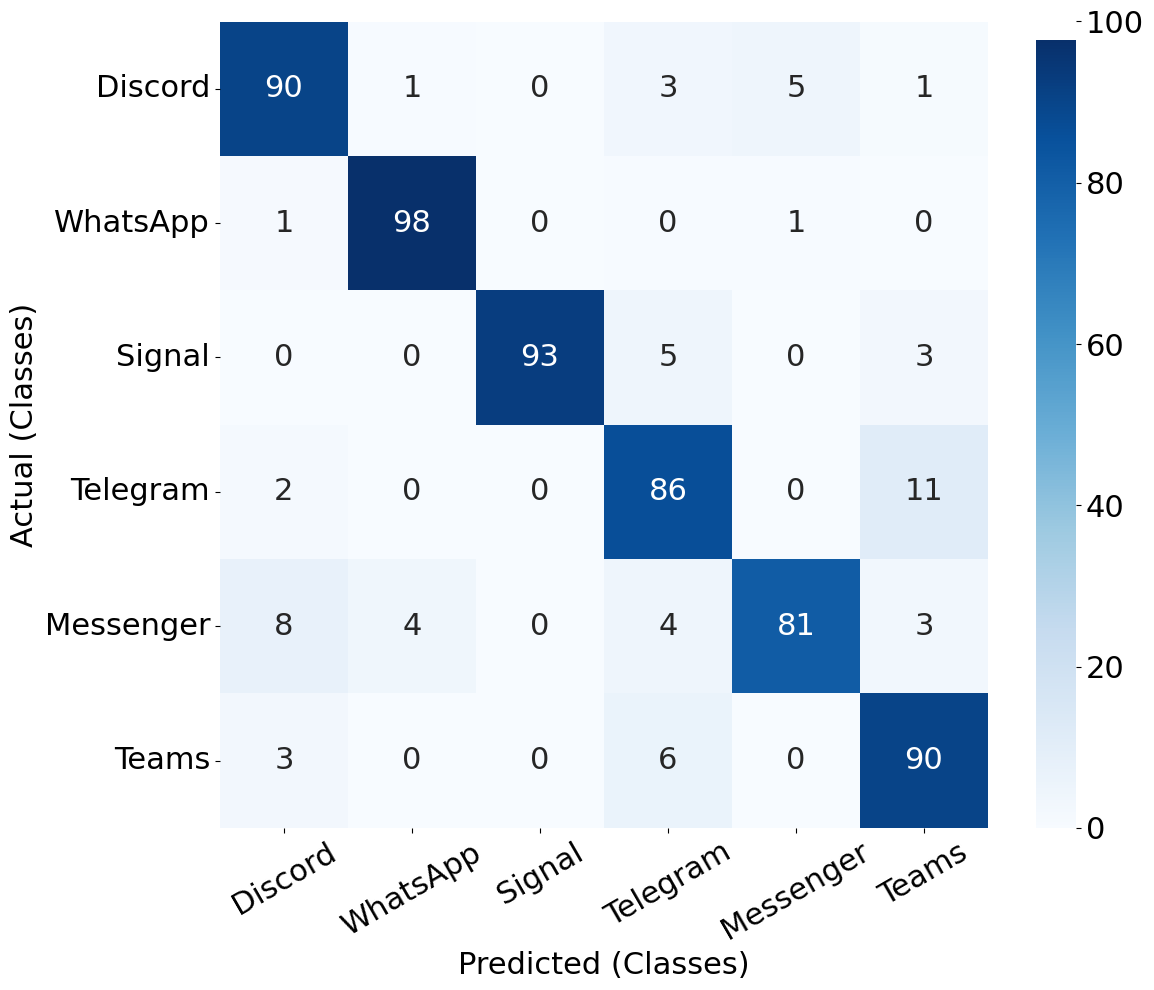

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
print(df.columns)
accuracy = class_report["accuracy"] * 100
precision = class_report["weighted avg"]["precision"] * 100
recall = class_report["weighted avg"]["recall"] * 100
weighted_f1 = class_report["weighted avg"]["f1-score"] * 100
macro_f1 = class_report["macro avg"]["f1-score"] * 100
X = test_data.drop(columns=["Label"])
y = test_data["Label"]

labels = sorted(y.unique())

# Call Plotting Functions
plot_confusion_matrix(conf_matrix, labels, save_path="confusion_matrix.pdf")
warnings.filterwarnings("ignore")


0        0
1        1
2        3
3        5
4        5
        ..
13543    2
13544    1
13545    2
13546    0
13547    5
Name: Label, Length: 13548, dtype: int64
[0 1 3 ... 2 0 5]

=== Per-Class Confusion Metrics ===
Class 0:
  - TP: 1689, TN: 11367, FP: 309, FN: 183
----------------------------------------
Class 1:
  - TP: 475, TN: 12976, FP: 86, FN: 11
----------------------------------------
Class 2:
  - TP: 2120, TN: 11234, FP: 24, FN: 170
----------------------------------------
Class 3:
  - TP: 1630, TN: 11073, FP: 590, FN: 255
----------------------------------------
Class 4:
  - TP: 1246, TN: 11913, FP: 97, FN: 292
----------------------------------------
Class 5:
  - TP: 4941, TN: 7730, FP: 341, FN: 536
----------------------------------------


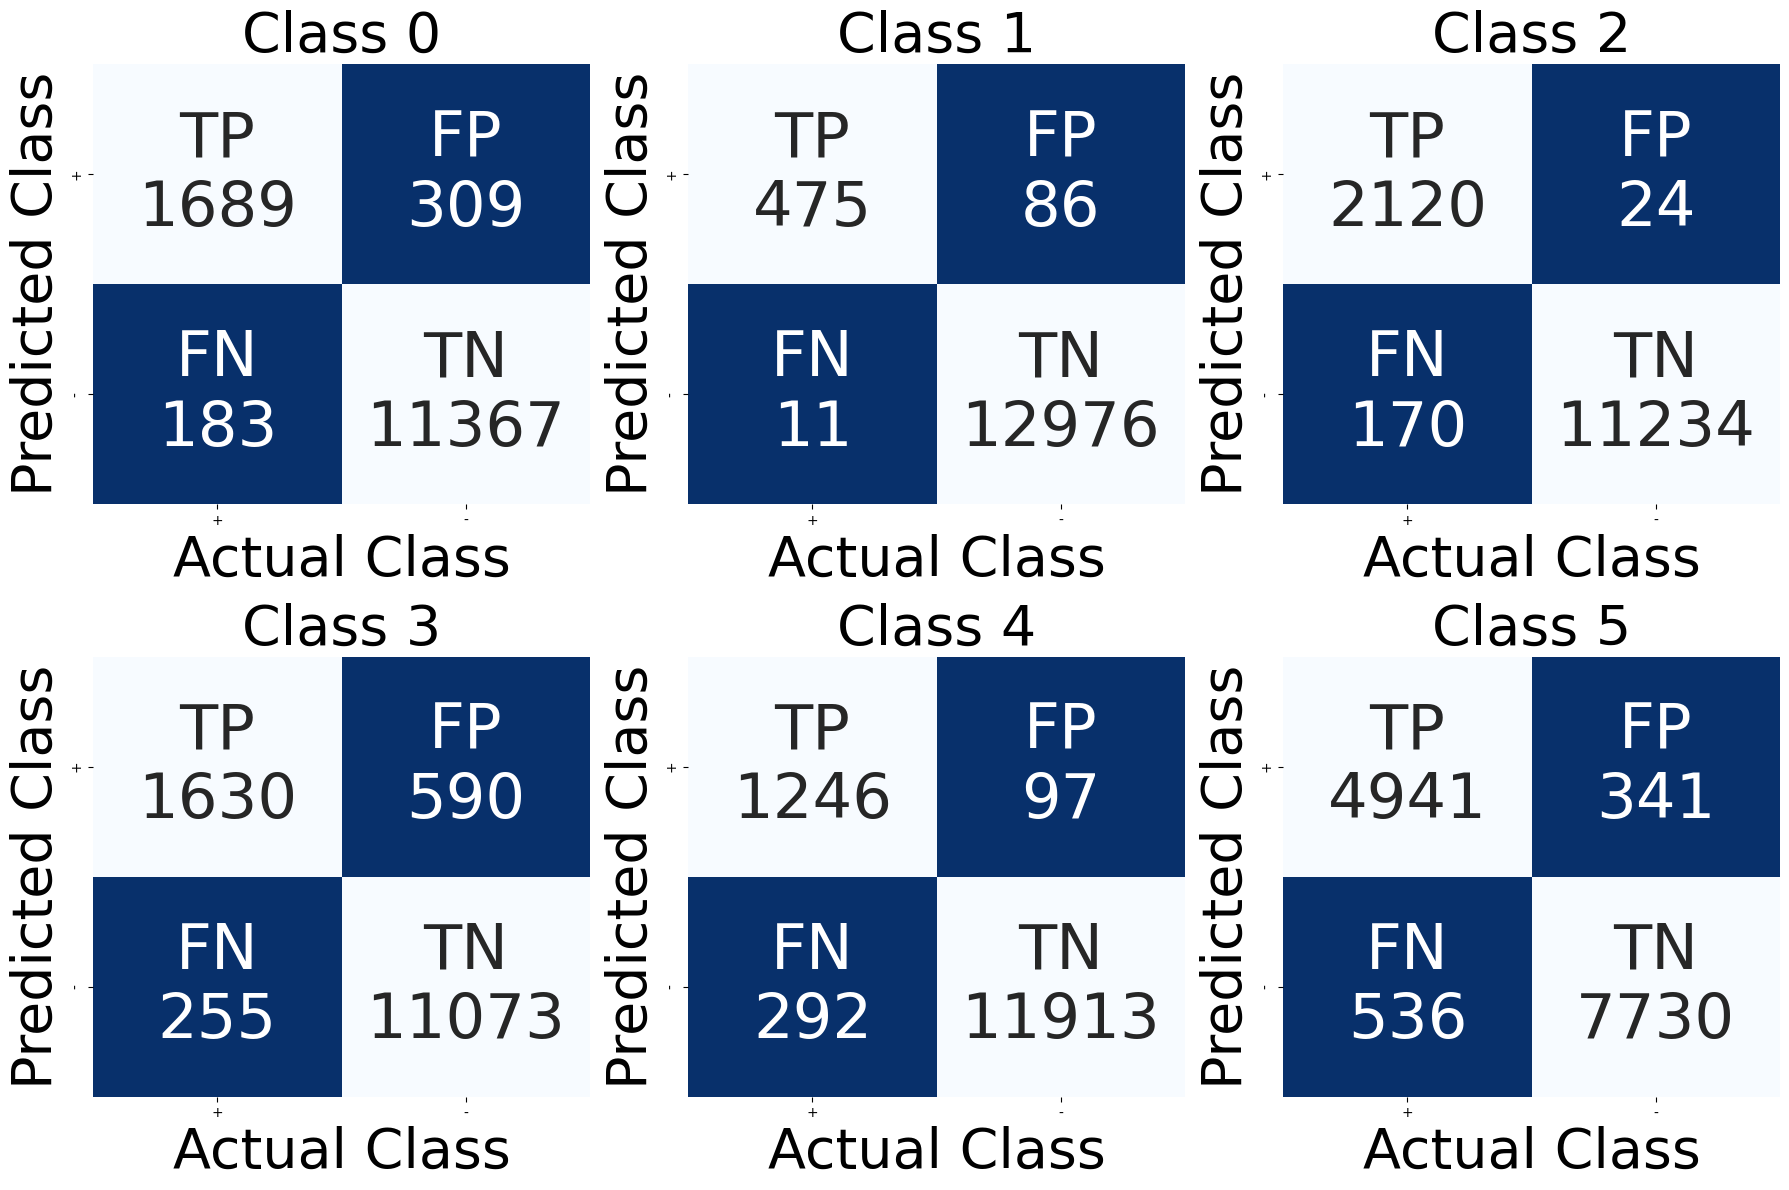

In [17]:
print(y_test)
print(y_pred)
display_per_class_metrics(y_test, y_pred)
plot_per_class_metrics(y_test, y_pred)

### Save the model

In [18]:
save_model(model, "rf_model_april_22nd_1pm.pkl")

### Testing data csv

In [19]:
test_data.to_csv("test_data.csv", index=False)